Changes:

* Subsetting to genes that are present in all data sources.. array, RNA-seq, and TEMPUS. 10363 genes.
* Subsetting the JIVE gene signatures to those present genes.

Questions: Are there missing genes, in array, that are present in RNA-seq, that would be better to have for TEMPUS?




In [1]:
#devtools::install_github("gibbsdavidl/robencla", force = F)

In [2]:
library(tidyverse)
library(robencla)
library(survival)
library(survminer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: R6

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: xgboost


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: plotROC

Loading required package: parallel

Loading required package: ROCit

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:sur

In [3]:
dat.m <- read_csv('data/Males_CV_Data_v3_GC.csv')
#pairgenes.m <- readRDS("../data/version3/pairgenes/pairgene_male_rounds_5.rds")
load("data/pairgenes/pairgene_male_rounds_8.rds")
# removing signature genes that are not available in our data sets
male.jive.gene.list <- readRDS("data/Males_jive_cluster_genes_v3_GC.rds") %>% dplyr::filter(value %in% colnames(dat.m))

Rows: 148 Columns: 10344
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr     (2): sample, cluster.group
dbl (10342): ARHGEF10L, HIF3A, RNF17, RNF10, RNF11, RNF13, REM1, TSKS, ATRX,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
table(male.jive.gene.list$cluster.group)


cluster1 cluster2 cluster3 cluster4 cluster5 
      12       46       79        7      179 

In [5]:
length(pairgenes)

[1] 17

In [6]:

sigs.m <- list("C1"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster1'],
               "C2"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster2'],
               "C3"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster3'],
               "C4"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster4'],
               "C5"=male.jive.gene.list$value[male.jive.gene.list$cluster.group == 'cluster5']
)

# our classifier object named Anne.
anne <- Robencla$new("Anne")

# xgboost parameters to pass to each sub-classifier in the ensembles
params <- list(max_depth=12,    # "height" of the tree, 6 is actually default. I think about 12 seems better.  (xgboost parameter)
               eta=0.1,        # this is the learning rate. smaller values slow it down, more conservative   (xgboost parameter)
               nrounds=42,     # number of rounds of training, lower numbers less overfitting (potentially)  (xgboost parameter)
               nthreads=6,     # parallel threads
               gamma=1,        # Minimum loss reduction required to again partition a leaf node. higher number ~ more conservative (xgboost parameter)
               lambda=1.5,     # L2 regularization term on weights, higher number ~ more conservative (xgboost parameter)
               alpha=0.5,      # L1 regularization term on weights. higher number ~ more conservative (xgboost parameter)
               verbose=0)


In [8]:
traindf <- data.table::fread(file='data/Males_CV_Data_v3_GC.csv',sep = ',',header = T)
testdf <- data.table::fread(file="data/Males_Tempus_Test_v3_GC.csv",sep = ',',header = T)

# traindf$cluster.group <- ifelse(traindf$cluster.group == 'cluster5', yes='cluster5', no='other_cluster')
# testdf$cluster.group <- ifelse(testdf$cluster.group == 'cluster5', yes='cluster5', no='other_cluster')

In [9]:

# First we use the training data
anne$autotrain(data_frame=traindf,
               label_name='cluster_group',
               sample_id = 'sample',
               data_mode=c('pairs'), # pairs,sigpairs,quartiles,tertiles,binarize,ranks,original #
               signatures=NULL,
               pair_list=pairgenes,  # subset to these genes.
               size=18,
               params=params,
               train_perc=0.8,
               combine_function='median')


Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”


In [10]:
anne$autotest(data_frame=testdf, 
               label_name='cluster_group',
               sample_id = 'sample')


[1] "TEST DATA CONTAINS ZERO VARIANCE COLUMNS"
[1] "...filling with random noise..."


In [11]:
df.m.tempus <- anne$results(include_label = T)
df.m.tempus[1:5,]

,SampleIDs,BestCalls,cluster1,cluster4,cluster2,cluster5,cluster3,Label
,<chr>,<chr>,<list>,<list>,<list>,<list>,<list>,<chr>
UM019,UM019,cluster5,0.2267217,0.1010297,0.2585546,0.2184245,0.1952694,NA
UM137,UM137,cluster1,0.2709636,0.1578583,0.2344583,0.1136971,0.2230227,NA
UM015,UM015,cluster5,0.08194415,0.06220688,0.1959191,0.4964719,0.163458,NA
UM042,UM042,cluster5,0.1668547,0.05082774,0.2771127,0.3550263,0.1501785,NA
UM123,UM123,cluster2,0.2042329,0.05809463,0.4131767,0.1418485,0.1826473,NA


In [12]:
table(Pred=df.m.tempus$BestCalls)

Pred
cluster1 cluster2 cluster3 cluster5 
      37       19       57       37 

In [14]:
tempus.clin <- read.csv('data/TEMPUS_Clinical_Data.csv')

In [15]:
head(tempus.clin)

,Study.ID,Age.at.diagnosis,Sex,Race,Ethnicity,KPS,EOR,MGMT,IDH1,Study,Survival.months,Vital.Status
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
1,UM001,58,Male,White,Non-hispanic,NA,Subtotal,Unmethylated,WT,UM,7.081967,0
2,UM002,65,Male,White,Non-hispanic,70+,Subtotal,Methylated,WT,UM,16.032787,0
3,UM003,84,Female,White,Non-hispanic,70+,Biopsy,Unmethylated,WT,UM,2.032787,1
4,UM004,65,Male,Other,Non-hispanic,70+,Gross Total,Unmethylated,WT,UM,16.918033,0
5,UM005,49,Male,NA,Non-hispanic,NA,Gross Total,Unmethylated,WT,UM,14.524590,0
6,UM006,60,Male,White,Non-hispanic,70+,Biopsy,NA,WT,UM,16.852459,0


In [16]:
df.m.tempus$SampleIDs <- gsub("_"," ",df.m.tempus$SampleIDs)
tempus.clin.m.cluster <- inner_join(tempus.clin, df.m.tempus[,c("SampleIDs","BestCalls")], by=c("Study.ID" = "SampleIDs"))

In [17]:
tempus.clin.m.cluster[1:5,]

,Study.ID,Age.at.diagnosis,Sex,Race,Ethnicity,KPS,EOR,MGMT,IDH1,Study,Survival.months,Vital.Status,BestCalls
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>
1,UM001,58,Male,White,Non-hispanic,NA,Subtotal,Unmethylated,WT,UM,7.081967,0,cluster1
2,UM002,65,Male,White,Non-hispanic,70+,Subtotal,Methylated,WT,UM,16.032787,0,cluster5
3,UM004,65,Male,Other,Non-hispanic,70+,Gross Total,Unmethylated,WT,UM,16.918033,0,cluster3
4,UM005,49,Male,NA,Non-hispanic,NA,Gross Total,Unmethylated,WT,UM,14.524590,0,cluster3
5,UM006,60,Male,White,Non-hispanic,70+,Biopsy,NA,WT,UM,16.852459,0,cluster1


In [18]:
t.m.fit <- survfit(Surv(Survival.months,Vital.Status)~BestCalls,data=tempus.clin.m.cluster)
t.m.fit

Call: survfit(formula = Surv(Survival.months, Vital.Status) ~ BestCalls, 
    data = tempus.clin.m.cluster)

   6 observations deleted due to missingness 
                    n events median 0.95LCL 0.95UCL
BestCalls=cluster1 36     28   18.4    16.2    24.4
BestCalls=cluster2 17     12   23.2    16.8      NA
BestCalls=cluster3 56     45   19.6    16.6    23.3
BestCalls=cluster5 35     27   19.1    15.3    28.3

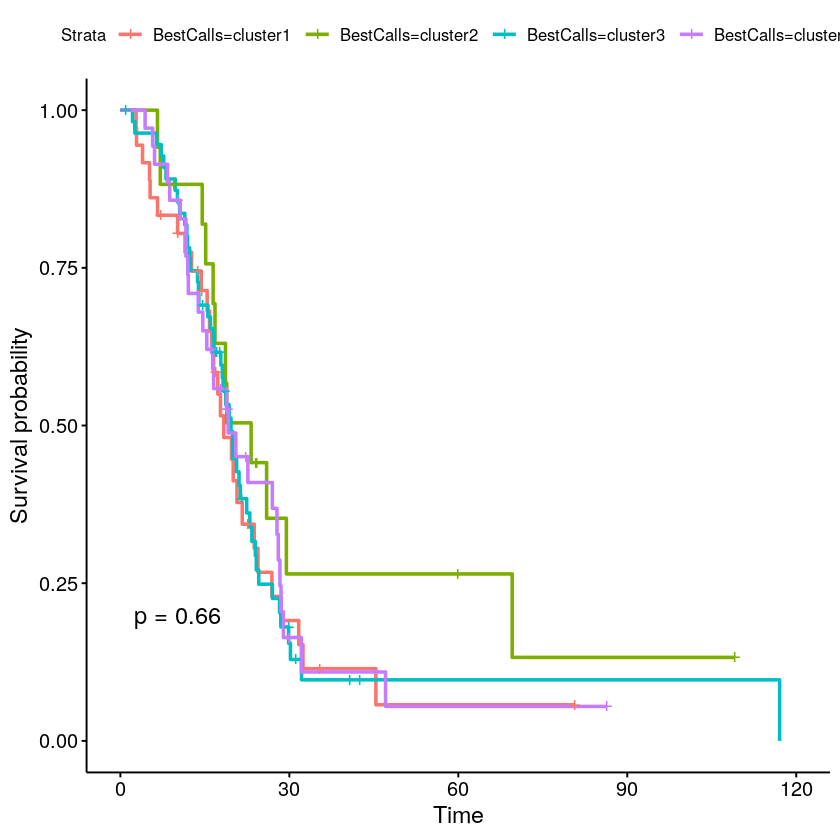

In [19]:
ggsurvplot(t.m.fit, pval = T)

In [58]:
tempus.m <- read.csv('../data/version3/Males_Tempus_Test_v3.csv')
tempus.m$sample <- gsub("_"," ",tempus.m$sample)

tempus.m.clus <- left_join(tempus.m[,c("sample",pairgenes)],df.m.tempus[,c("SampleIDs","BestCalls")],, by = c("sample" = "SampleIDs"))  
tempus.m.clus.plot.data <- reshape2::melt(tempus.m.clus, na.rm = FALSE, value.name = "G.Exp", id = c('sample','BestCalls'))

ERROR: Error in `[.data.frame`(tempus.m, , c("sample", pairgenes)): undefined columns selected


In [ ]:
ggplot(data = tempus.m.clus.plot.data, aes(x=BestCalls,y=G.Exp, fill=BestCalls)) +
  geom_boxplot() + facet_wrap(~variable)